# Tarea Dask

## Instrucciones generales
- Esta tarea debe realizarse de manera individual
- Este notebook (resuelto) debe ser subido al github del proyecto en la carpeta de tareas (creen una carpeta dentro de esa carpeta y agreguen su notebook reuelto)
- Fecha límite: Lunes 25 de noviembre de 2024 a las 11:59 p.m
- Deben realizar las cuatro secciones
- Puedes agregar tantas celdas de código y explicaciones como veas necesario, solo manten la estructura general

## Sección 0 Creación y Configuración del cliente de Dask
Ejercicio 0: Configuración del cliente
1. Crea un cliente local de Dask que inicie un clúster en tu máquina.
2. Configura el cliente para que tenga las siguientes características (elige un par de las opciones de trabajadores e hilos):
    - Número de trabajadores: 2 / 4
    - Memoria máxima por trabajador: 1GB
    - Threads por trabajador: 4 / 2
3. Verifica que el cliente esté funcionando correctamente mostrando:
    - Resumen de los trabajadores activos.
    - Dashboard disponible (URL del panel de control de Dask).
    * Tip: Checa los parámetros del cliente que creeaste.

*Nota*: Puedes hacer que corra en el puerto que desees.

In [1]:
#Importamos todo
import dask
from dask.distributed import Client, as_completed
import dask.array as da
import dask.dataframe as dd
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt

In [2]:

client = Client(n_workers=2, threads_per_worker=4,  memory_limit='1GB',dashboard_address=':8882')


client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8882/status,
Dashboard: http://127.0.0.1:8882/status,Workers: 2
Total threads: 8,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35389,Workers: 2
Dashboard: http://127.0.0.1:8882/status,Total threads: 8
Started: Just now,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:44429,Total threads: 4
Dashboard: http://127.0.0.1:41123/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:38915,


## Sección 1 Delayed
Ejercicio 1: Procesamiento de datos 

1. Genera datos simulados (por ejemplo, ventas diarias) para 10 sucursales durante 365 días.
    - Cada sucursal debe tener datos generados aleatoriamente para "Ingresos" y "Costos".
    - Utiliza una función para generar los datos simulados.
2. Usa Dask Delayed para calcular:
    - Las ganancias diarias por sucursal.
    - La sucursal con mayor ganancia promedio.
3. Genera un grafo de tareas que visualice estas operaciones y explica por qué elegiste paralelizar de esa forma, genera una visualización del grafo.

Resultados:
Sucursal con mayor ganancia promedio: 1
Ganancia promedio: $313.13


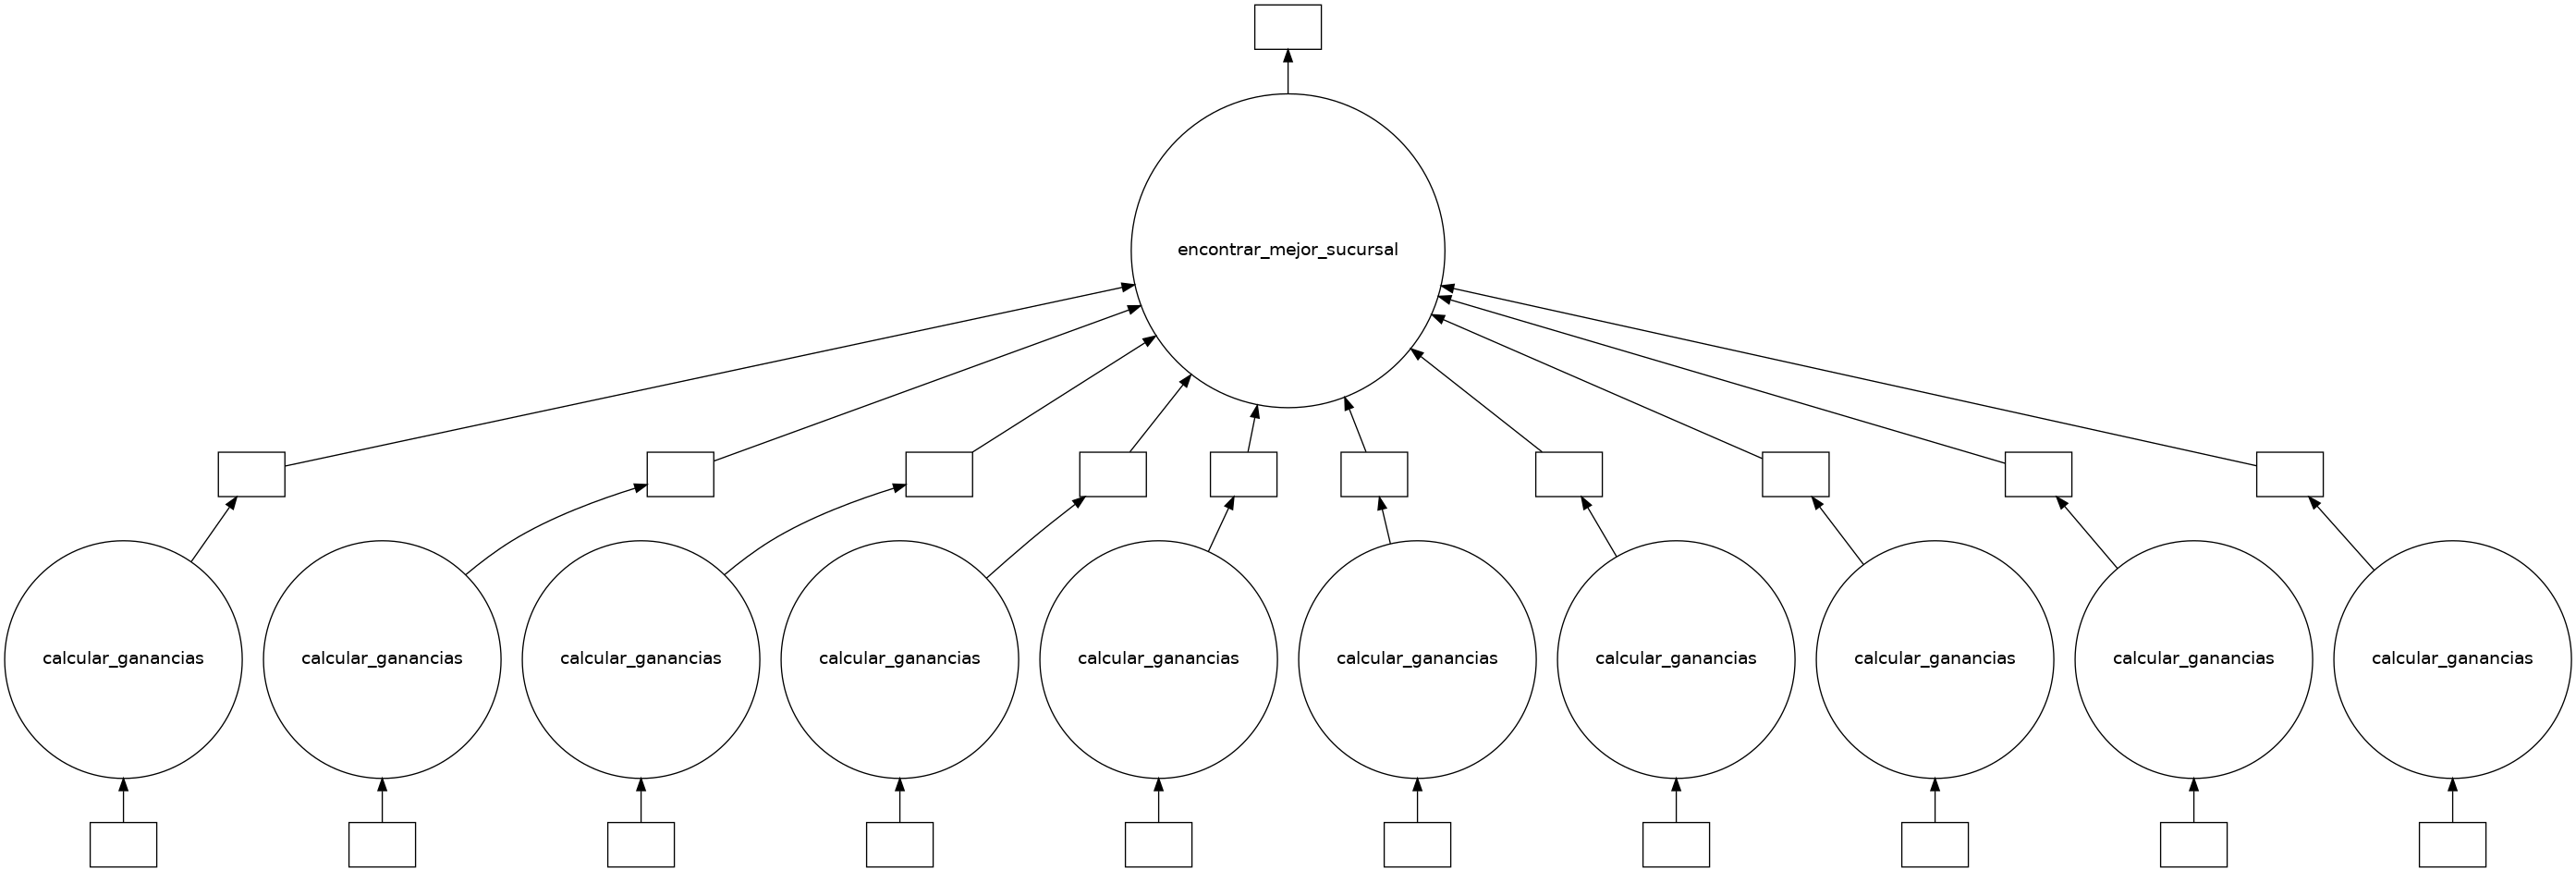

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dask import delayed

# Configuración de semilla para reproducibilidad
np.random.seed(42)

# Generar datos simulados para 10 sucursales
sucursales_datos = []
for id_sucursal in range(10):
    # Generar fechas para 365 días
    fechas = [datetime(2024, 1, 1) + timedelta(days=i) for i in range(365)]
    
    # Generar ingresos y costos aleatorios
    ingresos = np.random.normal(1000, 200, 365)
    costos = np.random.normal(700, 150, 365)
    
    # Crear DataFrame
    df = pd.DataFrame({
        'fecha': fechas,
        'sucursal': id_sucursal,
        'ingresos': ingresos,
        'costos': costos
    })
    
    # Aplicar Dask Delayed
    sucursal_delayed = delayed(df)
    sucursales_datos.append(sucursal_delayed)

# Calcular ganancias para cada sucursal
ganancias_sucursales = []
for sucursal_data in sucursales_datos:
    @delayed
    def calcular_ganancias(df):
        return df.assign(ganancias=df['ingresos'] - df['costos'])
    
    ganancias = calcular_ganancias(sucursal_data)
    ganancias_sucursales.append(ganancias)

# Encontrar la sucursal con mayor ganancia promedio
@delayed
def encontrar_mejor_sucursal(dataframes):
    # Concatenar todos los DataFrames
    datos_completos = pd.concat(dataframes)
    
    # Calcular ganancias promedio por sucursal
    ganancias_por_sucursal = datos_completos.groupby('sucursal')['ganancias'].mean()
    
    # Encontrar la sucursal con mayor ganancia
    mejor_sucursal = ganancias_por_sucursal.idxmax()
    ganancia_maxima = ganancias_por_sucursal.max()
    
    return mejor_sucursal, ganancia_maxima

# Crear tarea final para encontrar la mejor sucursal
mejor_sucursal = encontrar_mejor_sucursal(ganancias_sucursales)

# Computar resultados
resultado = mejor_sucursal.compute()

print("Resultados:")
print(f"Sucursal con mayor ganancia promedio: {resultado[0]}")
print(f"Ganancia promedio: ${resultado[1]:.2f}")

# Visualizar grafo de tareas
mejor_sucursal.visualize(filename="grafo_mejor_sucursal.png", format="png")


Porque agiliza el calculo individual de las operaciones para cada local. Se pueden calcular de manera paralela al mismo tiempo.

## Sección 2 Dask Dataframes
Ejercicio 2: Limpieza y análisis de datos reales

1. Descarga un conjunto de datos masivo (puedes usar la colección de *nycflights* que se encuentra en `data/nycflights/`).
2. Carga los datos en un Dask DataFrame. 
    - Elige adecuadamente el número de particiones (que quepan en memoria de los `workers`)
3. Realiza las siguientes tareas:
    - Limpia los valores faltantes en las columnas `ArrDelay` y `DepDelay`, rellenándolos con la mediana de cada columna.
    - Calcula el retraso promedio (`DepDelay`) por mes y aerolínea.
    - Encuentra el aeropuerto de origen con más vuelos retrasados.

*Nota*: **Evita** convertir el DataFrame a pandas e **intenta** realizar `.compute()` solo cuando sea necesario.

In [4]:
import dask.dataframe as dd

# Paso 1: Cargar los datos masivos en un Dask DataFrame
# Cambia 'path_to_data' a la ruta de tu conjunto de datos
path_to_data = "data/nycflights/*.csv"
df = dd.read_csv(path_to_data, assume_missing=True)

# Paso 2: Elegir un número adecuado de particiones
# Ajusta según la memoria disponible en tu máquina o clúster
df = df.repartition(npartitions=4)

# Paso 3: Limpieza de valores faltantes
# Calcular la mediana de las columnas 'ArrDelay' y 'DepDelay'
arr_delay_median = df['ArrDelay'].quantile(0.5).compute()
dep_delay_median = df['DepDelay'].quantile(0.5).compute()

# Rellenar valores faltantes con las medianas calculadas
df = df.fillna({'ArrDelay': arr_delay_median, 'DepDelay': dep_delay_median})

# Paso 4: Retraso promedio (DepDelay) por mes y aerolínea
retraso_promedio = df.groupby(['Month', 'UniqueCarrier'])['DepDelay'].mean().compute()
print("Retraso promedio (DepDelay) por mes y aerolínea:")
print(retraso_promedio)

# Paso 5: Aeropuerto de origen con más vuelos retrasados
# Un vuelo se considera retrasado si DepDelay > 0
df['Delayed'] = df['DepDelay'] > 0

# Contar los vuelos retrasados por aeropuerto de origen
vuelos_retrasados = df.groupby('Origin')['Delayed'].sum().compute()

# Encontrar el aeropuerto con más vuelos retrasados
aeropuerto_mas_retrasos = vuelos_retrasados.idxmax()
print("\nAeropuerto de origen con más vuelos retrasados:")
print(f"{aeropuerto_mas_retrasos} ({vuelos_retrasados[aeropuerto_mas_retrasos]} vuelos retrasados)")


Retraso promedio (DepDelay) por mes y aerolínea:
Month  UniqueCarrier
1.0    AA                8.963504
       CO               11.693346
       DL                9.249338
       EA               24.258191
       HP               18.697144
                          ...    
12.0   NW                9.705670
       PA (1)            8.154915
       TW               15.067855
       UA                8.790345
       US               11.683855
Name: DepDelay, Length: 130, dtype: float64

Aeropuerto de origen con más vuelos retrasados:
EWR (564404 vuelos retrasados)


## Sección 3 Dask Arrays

Ejercicio 3: Procesamiento numérico avanzado

1. Crea un arreglo de 10,000 x 10,000 con valores aleatorios usando Dask Array, utiliza un tamaño de chunks adecuado, ¿es mejor que sean cuadrados?.
2. Realiza las siguientes operaciones:
    - Calcula la suma de cada fila.
    - Encuentra la fila con el valor máximo promedio.
    - Multiplica todo el arreglo por un factor escalar (por ejemplo, 2.5).
3. Divide el arreglo nuevamente en 100 bloques y compara la rapidez.

In [9]:
import dask.array as da
import time

# Crear un array grande con chunks iniciales
arr = da.random.random((10000, 10000), chunks=(1000, 1000))

# Operaciones con el array original
start_time = time.time()
row_sums = arr.sum(axis=1)  # Suma de cada fila
row_means = arr.mean(axis=1)  # Promedio de cada fila
max_row_idx = row_means.argmax()  # Índice de la fila con el máximo promedio
scaled_arr_mean = (arr * 2.5).mean()  # Promedio del array multiplicado por 2.5

# Computear todo junto para el array original
results_original = da.compute(row_sums, row_means, max_row_idx, scaled_arr_mean)
time_original = time.time() - start_time

# Redividir el array en 100 bloques (10x10 chunks)
new_chunks = (arr.shape[0] // 10, arr.shape[1] // 10)
repartitioned_arr = arr.rechunk(new_chunks)

# Operaciones con el array reparticionado
start_time = time.time()
re_row_sums = repartitioned_arr.sum(axis=1)
re_row_means = repartitioned_arr.mean(axis=1)
re_max_row_idx = re_row_means.argmax()
re_scaled_arr_mean = (repartitioned_arr * 2.5).mean()

# Computear todo junto para el array reparticionado
results_repartitioned = da.compute(re_row_sums, re_row_means, re_max_row_idx, re_scaled_arr_mean)
time_repartitioned = time.time() - start_time

# Desempaquetar resultados
row_sums, row_means, max_row_idx, scaled_arr_mean = results_original
re_row_sums, re_row_means, re_max_row_idx, re_scaled_arr_mean = results_repartitioned

# Imprimir resultados y tiempos
print("Resultados:")
print(f"Suma de cada fila (original): {row_sums[:5]}...")  # Mostrar las primeras 5 filas
print(f"Índice de la fila con mayor valor promedio (original): {max_row_idx}")
print(f"Media del array escalado (original): {scaled_arr_mean}")
print(f"Tiempo con array original: {time_original:.2f} segundos")

print(f"\nSuma de cada fila (reparticionado): {re_row_sums[:5]}...")
print(f"Índice de la fila con mayor valor promedio (reparticionado): {re_max_row_idx}")
print(f"Media del array escalado (reparticionado): {re_scaled_arr_mean}")
print(f"Tiempo con array reparticionado: {time_repartitioned:.2f} segundos")



Resultados:
Suma de cada fila (original): [5005.6872572  5018.73847379 5000.67895751 4991.80682634 4985.01541117]...
Índice de la fila con mayor valor promedio (original): 8331
Media del array escalado (original): 1.2501849086860588
Tiempo con array original: 10.20 segundos

Suma de cada fila (reparticionado): [5005.6872572  5018.73847379 5000.67895751 4991.80682634 4985.01541117]...
Índice de la fila con mayor valor promedio (reparticionado): 8331
Media del array escalado (reparticionado): 1.2501849086860588
Tiempo con array reparticionado: 5.31 segundos


In [ ]:
Es mejor que sean cuadrados porque la carga se puede distribuir de manera uniforme lo que facilita la carga para los workers.

## Sección 4 Futures
Ejercicio 4: Distribución de tareas dinámicas

1. Implementa una función que calcule la raíz cuadrada de una lista de 100,000 números enteros generados aleatoriamente.
2. Divide la lista en 10 partes iguales y usa Dask Futures para calcular la raíz cuadrada de cada parte en paralelo.
3. Recolecta los resultados y calcula:
    - El promedio de todos los números procesados.
    - El tiempo total de ejecución (incluyendo envío y recolección de tareas).
4. Observa como se distribuye la carga en el cliente.

*Nota*: en los ejercicios ya vimos como determinar si ya se cumplío una tarea.

In [10]:
import numpy as np
from dask.distributed import Client, as_completed
import time

# Paso 1: Configurar el cliente de Dask
client = Client()

# Paso 2: Implementar una función para calcular la raíz cuadrada
def calcular_raiz_cuadrada(numeros):
    return np.sqrt(numeros)

# Paso 3: Generar una lista de 100,000 números aleatorios
numeros = np.random.randint(1, 100000, size=100000)

# Paso 4: Dividir la lista en 10 partes iguales
chunk_size = len(numeros) // 10
partes = [numeros[i:i + chunk_size] for i in range(0, len(numeros), chunk_size)]

# Paso 5: Enviar las tareas al clúster utilizando Dask Futures
inicio_tiempo = time.time()

futures = [client.submit(calcular_raiz_cuadrada, parte) for parte in partes]


# Paso 6: Recolectar resultados
resultados = client.gather(futures)

# Combinar todos los resultados en un solo arreglo
resultados_combinados = np.concatenate(resultados)

# Calcular el promedio de todos los números procesados
promedio = resultados_combinados.mean()

fin_tiempo = time.time()

# Paso 7: Mostrar resultados y tiempo total de ejecución
print("Resultados:")
print(f"Promedio de todos los números procesados: {promedio:.2f}")
print(f"Tiempo total de ejecución (incluyendo envío y recolección): {fin_tiempo - inicio_tiempo:.2f} segundos")



/usr/local/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36047 instead
  warnings.warn(


Resultados:
Promedio de todos los números procesados: 210.90
Tiempo total de ejecución (incluyendo envío y recolección): 0.13 segundos
